In [ ]:
!nvidia-smi

Sun Feb 21 19:59:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
import torch.optim as optim

import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)

1.7.0+cu101


# **Model**

In [ ]:
# Model
class Siamese_Net(nn.Module):
  def __init__(self):
    super(Siamese_Net,self).__init__()

    self.conv1=nn.Conv2d(1,64,10)
    self.conv2=nn.Conv2d(64,128,7)
    self.conv3=nn.Conv2d(128,128,4)
    self.conv4=nn.Conv2d(128,256,4)

    self.Linear1=nn.Linear(9216,4096)
    self.flatten=nn.Flatten()
    self.Linear2=nn.Linear(4096,1)

    self.relu=nn.ReLU()
    self.maxP=nn.MaxPool2d(2)
    self.sigm=nn.Sigmoid()

    # self.initialize_weights()

  def twin(self,x):

    out=self.conv1(x)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv2(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv3(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv4(out)
    out=self.relu(out)

    # test=out.view(out.size()[0], -1)
    out=self.flatten(out)
    # print(test==out) ##result -> true

    out=self.Linear1(out)
    out=self.sigm(out)

    return out

  def forward(self,x1,x2):

    x1_out=self.twin(x1)
    x2_out=self.twin(x2)

    # score= linear(distance between vectors)
    score=self.Linear2(torch.abs(x1_out-x2_out))

    # print(score)
    
    return score

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,0,1e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)
      if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight,0,2e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)



In [ ]:
#testing
net=Siamese_Net()
# print(net)
dummyx1=torch.randn(64,1,105,105)
dummyx2=torch.randn(64,1,105,105)
o=net(dummyx1,dummyx2)
print(o.shape)

torch.Size([64, 1])


# **Face lfw Dataset**

In [ ]:
# Download and split dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xvzf /content/lfw-deepfunneled.tgz

os.mkdir('/content/lfw-deepfunneled_val')

train_dir='/content/lfw-deepfunneled'
val_dir='/content/lfw-deepfunneled_val'
total=len(os.listdir(train_dir))
print(f'TOTAL: {total}')
n_train_classes=int(total*0.8)
n_val_classes=total-n_train_classes

for _ in range(n_val_classes):
  ran_dir=random.choice(os.listdir(train_dir))
  os.rename(f"{train_dir}/{ran_dir}", f"{val_dir}/{ran_dir}")

print(f'CURRENT TOTAL TRAIN: {len(os.listdir(train_dir))}')

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg
lfw-deepfunne

In [ ]:

class Face_Dataset(Dataset):
  def __init__(self,root_dir, job='train',ways=10,transform=None):
    super(Face_Dataset,self).__init__()
    self.root_dir=root_dir
    self.job=job
    self.all_classes=os.listdir(root_dir)
    self.num_classes=len(self.all_classes)
    self.face_list, self.number_of_faces=self.get_face_list()
    self.ways=ways
    self.transform=transform
    print(self.all_classes)

  def __len__(self):
    return self.number_of_faces

  def __getitem__(self,idx):
    if self.job=='train':
      is_Same=1
      # Same person if even
      if idx%2==0:
        path_img_1,path_img_2,_=self.get_same()
      # different people 
      else:
        is_Same=0
        path_img_1,path_img_2=self.get_different()

      img1=Image.open(path_img_1).convert('L')
      img2=Image.open(path_img_2).convert('L')
      
      if self.transform:
        img1=self.transform(img1)
        img2=self.transform(img2)

      return img1,img2,torch.tensor([is_Same], dtype=torch.float32)

    else:
      img_list=[]
      ways=self.ways

      # grab two images from the same class
      path_img_1,path_img_2,id_to_avoid=self.get_same()
      img_list+=[path_img_1,path_img_2]

      ways=(ways-2)//2

      # and remaining from different classes
      for i in range(ways):
        img_list+=self.get_different(id_to_avoid)

      for i in range(len(img_list)):
        img=Image.open(img_list[i]).convert('L')
        if self.transform:
          img=self.transform(img)
        img_list[i]=img

      img_list_tensor=torch.stack(img_list)
      return img_list_tensor

  def get_face_list(self) -> (dict, int):
      p_list,n_faces={},0
      for idx, person in enumerate(self.all_classes):
        p_list[idx]=[]
        for face in os.listdir(os.path.join(self.root_dir,person)):
          p_list[idx].append(os.path.join(self.root_dir, person, face))
          n_faces+=1
      return p_list,n_faces

  def get_same(self) -> (str, str, int):
    person_id=random.randint(0,self.num_classes-1)
    path_img_1=random.choice(self.face_list[person_id])
    path_img_2=random.choice(self.face_list[person_id])
    return path_img_1,path_img_2,person_id

  def get_different(self, avoid=None)-> (str, str):

    person_id_1=random.randint(0,self.num_classes-1)
    while person_id_1==avoid:
      person_id_1=random.randint(0,self.num_classes-1)

    person_id_2=random.randint(0,self.num_classes-1)
    while person_id_2==person_id_1 or person_id_2==avoid:
      person_id_2=random.randint(0,self.num_classes-1)

    path_img_1=random.choice(self.face_list[person_id_1])
    path_img_2=random.choice(self.face_list[person_id_2])
    return path_img_1,path_img_2
      

In [ ]:
a=torch.randn((64,3,122,450),dtype=torch.float32)
b=torch.randn((64,3,122,450),dtype=torch.float32)
c=torch.randn((64,3,122,450),dtype=torch.float32)
l=[a,b,c]
lt=torch.stack(l)
print(lt.shape)
print(lt[0,:].shape)

torch.Size([3, 64, 3, 122, 450])
torch.Size([64, 3, 122, 450])


In [ ]:
# lfw root for train and val
train_root='/content/lfw-deepfunneled'
val_root='/content/lfw-deepfunneled_val'
batch_size=16
ways=10

In [ ]:
# Omniglot Calculating the mean and std of the data

def find_mean_std(datasets,batch_s=1):
  
  means_stds=[]
  for dataset in datasets:
    to_norm_loader=DataLoader(dataset=dataset, batch_size=batch_s)
    print('Total number of samples: ', len(dataset))

    # #run for 1 batch 
    # data_iter=iter(to_norm_loader)
    # img,_,__=data_iter.next()
    # print(img.shape)
    
    channels_sum, channels_squared_sum, num_batches=0, 0, 0
    for img,_,__ in to_norm_loader:
      # print(img.shape)#[batch,C,H,W]
      channels_sum+=torch.mean(img,dim=[0,2,3])
      channels_squared_sum+=torch.mean(img**2,dim=[0,2,3])
      num_batches+=1
    
    mean=channels_sum/num_batches
    std=(channels_squared_sum/num_batches- mean**2)**0.5
    means_stds.append(mean)
    means_stds.append(std)
  return means_stds

to_be_norm_dataset=Face_Dataset(train_root, transform=transforms.Compose([
                                                             transforms.Resize((105,105)),
                                                             transforms.ToTensor()
                                           ]))

to_be_norm_dataset_val=Face_Dataset(val_root, transform=transforms.Compose([
                                                             transforms.Resize((105,105)),
                                                             transforms.ToTensor()
                                           ]))

mean, std,mean_val,std_val= find_mean_std([to_be_norm_dataset, to_be_norm_dataset_val], batch_s=batch_size)

print(f'mean: {mean.item()}    std: {std.item()}     val mean: {mean_val.item()}    val std: {std_val.item()}')

['Budd_Schulberg', 'Glen_Clark', 'John_Blaney', 'Vince_Vaughan', 'Michael_McNeely', 'Larry_Campbell', 'Eric_Shinseki', 'Lidija_Djukanovic', 'Lars_Burgsmuller', 'Celine_Dion', 'Raquel_Welch', 'Carlos_Quintanilla_Schmidt', 'David_Zeplowitz', 'Jamie_Martin', 'Rita_Wilson', 'Michael_Rolinee', 'Veronica_Lake', 'Melissa_Etheridge', 'Bode_Miller', 'Marcelo_Rios', 'Kaisser_Bazan', 'Gwen_Stefani', 'Ruth_Pearce', 'Gabriel_Valdes', 'John_Lawrence', 'Marsah_Ambrosius', 'Felix_Mantilla', 'Chan_Gailey', 'Joan_Laporta', 'Branko_Crvenkovski', 'Mamdouh_Habib', 'Camille_Lewis', 'Chip_Ganassi', 'Mika_Hakkinen', 'Walid_Al-Awadi', 'Wayne_Newton', 'Rick_Lu', 'George_Plimpton', 'Teri_ORourke', 'Ron_Gonzales', 'Norah_Jones', 'Travis_Rudolph', 'Dieter_Holzer', 'Roberto_Guaterroma', 'John_Goold', 'Gen_Meredith', 'Sherry_Irving', 'Lili_Marinho', 'Todd_Wike', 'Ali_Khamenei', 'Jose_Luis_Chilavert', 'Kenneth_Evans', 'Alexander_Lukashenko', 'Demetrius_Ferraciu', 'Marcelo_Ebrard', 'Dai_Chul_Chyung', 'Cheryl_Ford', 'S

In [ ]:
# prepare datasets(LFW)

transform=transforms.Compose([
                              transforms.Resize((105,105)),
                              transforms.RandomAffine(30,shear=0.2),
                              transforms.ToTensor(),
                              transforms.Normalize([mean.item()],[std.item()]),
])
# dataset=Face_Dataset(root,transform=transform)
dataset_train=Face_Dataset(train_root, transform=transform)
dataset_val=Face_Dataset(val_root,job='val', ways=ways, transform=transforms.Compose([transforms.Resize((105,105)),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize([mean_val.item()],[std_val.item()])
                                                            ])
)

dataloader_train=DataLoader(dataset=dataset_train, batch_size=batch_size)
dataloader_val=DataLoader(dataset=dataset_val, batch_size=batch_size)


['Budd_Schulberg', 'Glen_Clark', 'John_Blaney', 'Vince_Vaughan', 'Michael_McNeely', 'Larry_Campbell', 'Eric_Shinseki', 'Lidija_Djukanovic', 'Lars_Burgsmuller', 'Celine_Dion', 'Raquel_Welch', 'Carlos_Quintanilla_Schmidt', 'David_Zeplowitz', 'Jamie_Martin', 'Rita_Wilson', 'Michael_Rolinee', 'Veronica_Lake', 'Melissa_Etheridge', 'Bode_Miller', 'Marcelo_Rios', 'Kaisser_Bazan', 'Gwen_Stefani', 'Ruth_Pearce', 'Gabriel_Valdes', 'John_Lawrence', 'Marsah_Ambrosius', 'Felix_Mantilla', 'Chan_Gailey', 'Joan_Laporta', 'Branko_Crvenkovski', 'Mamdouh_Habib', 'Camille_Lewis', 'Chip_Ganassi', 'Mika_Hakkinen', 'Walid_Al-Awadi', 'Wayne_Newton', 'Rick_Lu', 'George_Plimpton', 'Teri_ORourke', 'Ron_Gonzales', 'Norah_Jones', 'Travis_Rudolph', 'Dieter_Holzer', 'Roberto_Guaterroma', 'John_Goold', 'Gen_Meredith', 'Sherry_Irving', 'Lili_Marinho', 'Todd_Wike', 'Ali_Khamenei', 'Jose_Luis_Chilavert', 'Kenneth_Evans', 'Alexander_Lukashenko', 'Demetrius_Ferraciu', 'Marcelo_Ebrard', 'Dai_Chul_Chyung', 'Cheryl_Ford', 'S

# Check if the datasets are working

0.0
torch.Size([1, 105, 105]) 
 torch.Size([1, 105, 105])
(105, 105) 
 (105, 105)


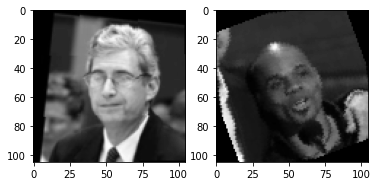

In [ ]:
# Testing train Dataset
img1,img2,are_Same=dataset_train[1]

print(are_Same.item())
print(img1.shape,'\n',img2.shape)

# convert to PIL and multiply with std and add mean to un-normalize the images for viewing purposes only
show_img1=transforms.ToPILImage()(img1.mul_(std).add_(mean))
show_img2=transforms.ToPILImage()(img2.mul_(std).add_(mean))

print(show_img1.size,'\n',show_img2.size)

plt.subplot(121)
plt.imshow(show_img1,cmap='gray')

plt.subplot(122)
plt.imshow(show_img2,cmap='gray')


torch.Size([10, 1, 105, 105]) torch.Size([1, 105, 105])


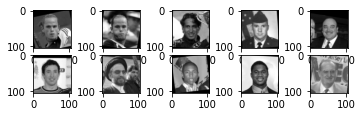

In [ ]:
# Testing validation Dataset
imgs=dataset_val[0]

print(imgs.shape, imgs[0,:].shape)

# data_iter=iter(dataloader_val)
# images=data_iter.next()
# print(images.shape) #torch.Size([16, 10, 1, 105, 105])

for i in range(ways):
  img=imgs[i,:]
  plt.subplot(5,5,(i+1))
  plt.imshow(transforms.ToPILImage()(img.mul_(std_val).add_(mean_val)), cmap='gray')


# Training

In [ ]:
resume_training=False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)

loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=3e-4,weight_decay=6e-5)

# lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
# lr_scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=True)

start_epoch=0
epochs=80

if resume_training:
  checkpoint = torch.load('/content/drive/MyDrive/dataset/ckpts_newest_2/checkp60.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  # loss_function = checkpoint['loss']

In [ ]:
# Train Network

save_ckp_at='/content/drive/MyDrive/DeepFaceLab_2/DeepFaceLab/doc/ckpt_lfw'
t_loss,accuracy=[],[]
val_every=1
save_every=20

for epoch in range(start_epoch, epochs+1):
  t_loss_batch=[]
  
  # ----------------------training---------------------------------------------
  model.train()
  for batch_idx, (img1, img2, isSame) in enumerate(dataloader_train):
    # Get data to cuda if possible
    img1, img2, isSame= img1.to(device),img2.to(device),isSame.to(device)

    # forward
    scores = model(img1, img2)
    loss = loss_function(scores, isSame)
    
    # backward
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    t_loss_batch.append(loss.item())
  
  mean_loss=sum(t_loss_batch)/len(t_loss_batch)
  t_loss.append(mean_loss)
  # ------------------------lr scheduler---------------------------------------------
  
  # for ExponentialLR 
  # lr_scheduler.step()
  
  # forReduceLROnPlateau
  # lr_scheduler.step(mean_loss)
  
  # -----------------------------Validation----------------------------------
  if epoch%val_every==0:
    model.eval()
    with torch.no_grad():
      batch_accuracy=[]
      for batch_idx,images in enumerate(dataloader_val):
        score_l,correct=[],0
        images=images.to(device)
        img1=images[:,0,:]

        for i in range(1,ways):
          score=torch.sigmoid(model(img1,images[:,i,:]))
          score_l.append(score)

        scores=torch.stack(score_l)

        results=torch.argmax(scores,0)

        for i in range(results.shape[0]):
          if results[i,:].item()==0:
            correct+=1

        total=images.shape[0]
        batch_accuracy.append(correct/total)

      # finding the accuracy of that epoch
      accuracy.append(sum(batch_accuracy)/len(batch_accuracy))
    print(f'Epoch No.:{epoch} training loss:{t_loss[-1]}  validation accuracy:{accuracy[-1]*100}%')
  
  if epoch%save_every==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': t_loss[-1],
            }, f'{save_ckp_at}/checkp_lfw{epoch}.pt')
    

Epoch No.:0 training loss:0.44824521094325587  validation accuracy:42.7405498281787%
Epoch No.:1 training loss:0.37178678376958574  validation accuracy:64.67998281786942%
Epoch No.:2 training loss:0.3238144231966053  validation accuracy:70.90850515463917%
Epoch No.:3 training loss:0.3125357764129665  validation accuracy:73.8939003436426%
Epoch No.:4 training loss:0.30169429767536066  validation accuracy:76.5786082474227%
Epoch No.:5 training loss:0.29973554854466333  validation accuracy:82.57087628865979%
Epoch No.:6 training loss:0.28241092727551886  validation accuracy:68.59965635738831%
Epoch No.:7 training loss:0.2674266890349448  validation accuracy:82.25945017182131%
Epoch No.:8 training loss:0.2645635325050316  validation accuracy:72.12199312714776%
Epoch No.:9 training loss:0.25641780737376174  validation accuracy:73.81872852233677%
Epoch No.:10 training loss:0.2437618727786966  validation accuracy:81.90506872852235%
Epoch No.:11 training loss:0.24956868363879267  validation ac

Mean Loss: 0.178


Text(0, 0.5, 'Loss')

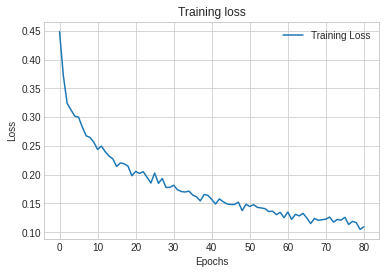

In [ ]:
print(f'Mean Loss: {sum(t_loss)/len(t_loss):.3f}')
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
ax.plot(t_loss,label='Training Loss')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Mean Accuracy: 87.070%
0.9220360824742269


Text(0, 0.5, 'Accuracy')

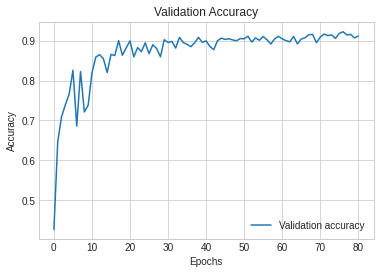

In [ ]:
print(f'Mean Accuracy: {sum(accuracy)/len(accuracy)*100:.3f}%')
print(max(accuracy))
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(accuracy,label='Validation accuracy')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

In [ ]:
# training accuracy for Omniglot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)
checkpoint = torch.load('/content/drive/MyDrive/DeepFaceLab_2/DeepFaceLab/doc/ckpt_lfw/checkp_lfw80.pt')
model.load_state_dict(checkpoint['model_state_dict'])

ways=10

dataset_train_acc=Face_Dataset(train_root,job='val', ways=ways,transform=transforms.Compose([
                                                                                             transforms.Resize((105,105)),
                                                                                             transforms.ToTensor(),
                                                                                             transforms.Normalize([mean.item()],[std.item()])
                                                                                             ]
))

dataloader_train_acc=DataLoader(dataset=dataset_train_acc, batch_size=batch_size)

# finding accuracy
model.eval()
with torch.no_grad():
  batch_accuracy=[]
  for batch_idx,images in enumerate(dataloader_train_acc):
    score_l,correct=[],0
    images=images.to(device)
    img1=images[:,0,:]

    for i in range(1,ways):
      score=torch.sigmoid(model(img1,images[:,i,:]))
      score_l.append(score)

    scores=torch.stack(score_l)

    results=torch.argmax(scores,0)

    for i in range(results.shape[0]):
      if results[i,:].item()==0:
        correct+=1

    total=images.shape[0]
    batch_accuracy.append(correct/total)
  print(f'Training accuracy: {sum(batch_accuracy)/len(batch_accuracy)*100:.3f}%')

['Budd_Schulberg', 'Glen_Clark', 'John_Blaney', 'Vince_Vaughan', 'Michael_McNeely', 'Larry_Campbell', 'Eric_Shinseki', 'Lidija_Djukanovic', 'Lars_Burgsmuller', 'Celine_Dion', 'Raquel_Welch', 'Carlos_Quintanilla_Schmidt', 'David_Zeplowitz', 'Jamie_Martin', 'Rita_Wilson', 'Michael_Rolinee', 'Veronica_Lake', 'Melissa_Etheridge', 'Bode_Miller', 'Marcelo_Rios', 'Kaisser_Bazan', 'Gwen_Stefani', 'Ruth_Pearce', 'Gabriel_Valdes', 'John_Lawrence', 'Marsah_Ambrosius', 'Felix_Mantilla', 'Chan_Gailey', 'Joan_Laporta', 'Branko_Crvenkovski', 'Mamdouh_Habib', 'Camille_Lewis', 'Chip_Ganassi', 'Mika_Hakkinen', 'Walid_Al-Awadi', 'Wayne_Newton', 'Rick_Lu', 'George_Plimpton', 'Teri_ORourke', 'Ron_Gonzales', 'Norah_Jones', 'Travis_Rudolph', 'Dieter_Holzer', 'Roberto_Guaterroma', 'John_Goold', 'Gen_Meredith', 'Sherry_Irving', 'Lili_Marinho', 'Todd_Wike', 'Ali_Khamenei', 'Jose_Luis_Chilavert', 'Kenneth_Evans', 'Alexander_Lukashenko', 'Demetrius_Ferraciu', 'Marcelo_Ebrard', 'Dai_Chul_Chyung', 'Cheryl_Ford', 'S

# **ROUGH**

In [ ]:
!wget http://www.gstatic.com/tv/thumb/persons/7530/7530_v9_bb.jpg https://m.media-amazon.com/images/M/MV5BMzczNzNiMDAtMmUzZS00MTkwLWIwOTYtNmYyNjg3MTVkNThhXkEyXkFqcGdeQXVyMjA4MjI5MTA@._V1_UY1200_CR135,0,630,1200_AL_.jpg https://m.media-amazon.com/images/M/MV5BZDk1ZmU0NGYtMzQ2Yi00N2NjLTkyNWEtZWE2NTU4NTJiZGUzXkEyXkFqcGdeQXVyMTExNDQ2MTI@._V1_UY1200_CR107,0,630,1200_AL_.jpg

--2021-02-22 22:43:37--  http://www.gstatic.com/tv/thumb/persons/7530/7530_v9_bb.jpg
Resolving www.gstatic.com (www.gstatic.com)... 172.217.203.94, 2607:f8b0:400c:c18::5e
Connecting to www.gstatic.com (www.gstatic.com)|172.217.203.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386858 (378K) [image/jpeg]
Saving to: ‘7530_v9_bb.jpg’

7530_v9_bb.jpg      100%[===================>] 377.79K  --.-KB/s    in 0.002s  

2021-02-22 22:43:37 (214 MB/s) - ‘7530_v9_bb.jpg’ saved [386858/386858]

--2021-02-22 22:43:37--  https://m.media-amazon.com/images/M/MV5BMzczNzNiMDAtMmUzZS00MTkwLWIwOTYtNmYyNjg3MTVkNThhXkEyXkFqcGdeQXVyMjA4MjI5MTA@._V1_UY1200_CR135,0,630,1200_AL_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88316 (86K) [image/jpeg]
Saving to: ‘MV5BMzczNzNiMDAtMmUzZS00M

In [ ]:
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)
checkpoint = torch.load('/content/drive/MyDrive/DeepFaceLab_2/DeepFaceLab/doc/ckpt_lfw/checkp_lfw80.pt',map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


path1='/content/7530_v9_bb.jpg'
path2='/content/MV5BMzczNzNiMDAtMmUzZS00MTkwLWIwOTYtNmYyNjg3MTVkNThhXkEyXkFqcGdeQXVyMjA4MjI5MTA@._V1_UY1200_CR135,0,630,1200_AL_.jpg'
path3='/content/MV5BZDk1ZmU0NGYtMzQ2Yi00N2NjLTkyNWEtZWE2NTU4NTJiZGUzXkEyXkFqcGdeQXVyMTExNDQ2MTI@._V1_UY1200_CR107,0,630,1200_AL_.jpg'

im1,im2,im3=Image.open(path1).convert('L'),Image.open(path2).convert('L'),Image.open(path3).convert('L')

tra=transforms.Compose([
                        transforms.Resize((105,105)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.38],[0.27]),
])

im1,im2,im3= torch.unsqueeze(tra(im1),0).to(device), torch.unsqueeze(tra(im2),0).to(device), torch.unsqueeze(tra(im3),0).to(device)

with torch.no_grad():
  op_same=torch.sigmoid(model(im1,im2))
  op_diff=torch.sigmoid(model(im1,im3))

  print(f'Same: {(op_same.item())*1e6}         Diff: {(op_diff.item())*1e6}')

Same: 4731.0469672083855         Diff: 3032.7877029776573
